# Loading Libraries & Dataset

In [1]:
!pip install factor-analyzer
!pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 12.7 MB/s eta 0:00:00
  Created wheel for factor-analyzer: filename=factor_analyzer-0.5.0-py2.py3-none-any.whl size=42487 sha256=047c9e6d558b38bb740a3d3707f05cf5c2132b30fbeb24150f514d4b01394744
  Stored in directory: /root/.cache/pip/wheels/74/a2/6c/26fb1addf1ce6c60a8cef8397f2999f0a1e6e2fcddc8abf33e
Successfully built factor-analyzer
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lit

In [2]:
import os
import zipfile
import tempfile
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
import numpy as np
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from matplotlib.lines import Line2D

In [3]:
os.environ['KAGGLE_USERNAME'] = "amrmnr"
os.environ['KAGGLE_KEY'] = "d3d03b858708a45d6516780c886c3bae"

In [4]:
!kaggle datasets download -d stefanoleone992/fifa-22-complete-player-dataset

 99% 107M/109M [00:05<00:00, 28.0MB/s]
100% 109M/109M [00:05<00:00, 20.4MB/s]


In [5]:
zip_file = zipfile.ZipFile('/content/fifa-22-complete-player-dataset.zip')
review_file = "players_22.csv"
temp_dir = tempfile.mkdtemp()
zip_file.extract(review_file, path=temp_dir)
extracted_file_path = f"{temp_dir}/{review_file}"

local_file_path = "/tmp/players_22.csv"
shutil.move(extracted_file_path, local_file_path)

df = pd.read_csv(local_file_path)
count = df.count()
print(count)

shutil.rmtree(temp_dir)

<ipython-input-5-5e129670adb3>:13: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(local_file_path)


sofifa_id           19239
player_url          19239
short_name          19239
long_name           19239
player_positions    19239
                    ...  
player_face_url     19239
club_logo_url       19178
club_flag_url       19178
nation_logo_url       759
nation_flag_url     19239
Length: 110, dtype: int64


# Data Preprocessing

In [6]:
print(len(df))
column_names = df.columns
column_names_str = ', '.join(column_names)
print(column_names_str)

19239
sofifa_id, player_url, short_name, long_name, player_positions, overall, potential, value_eur, wage_eur, age, dob, height_cm, weight_kg, club_team_id, club_name, league_name, league_level, club_position, club_jersey_number, club_loaned_from, club_joined, club_contract_valid_until, nationality_id, nationality_name, nation_team_id, nation_position, nation_jersey_number, preferred_foot, weak_foot, skill_moves, international_reputation, work_rate, body_type, real_face, release_clause_eur, player_tags, player_traits, pace, shooting, passing, dribbling, defending, physic, attacking_crossing, attacking_finishing, attacking_heading_accuracy, attacking_short_passing, attacking_volleys, skill_dribbling, skill_curve, skill_fk_accuracy, skill_long_passing, skill_ball_control, movement_acceleration, movement_sprint_speed, movement_agility, movement_reactions, movement_balance, power_shot_power, power_jumping, power_stamina, power_strength, power_long_shots, mentality_aggression, mentality_int

In [7]:
df.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,...,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,...,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,...,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png
3,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000.0,270000.0,29,...,50+3,50+3,50+3,62+3,20+3,https://cdn.sofifa.net/players/190/871/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,NaN,https://cdn.sofifa.net/flags/br.png
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,125500000.0,350000.0,30,...,69+3,69+3,69+3,75+3,21+3,https://cdn.sofifa.net/players/192/985/22_120.png,https://cdn.sofifa.net/teams/10/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png


In [8]:
df[['Position_1', 'Position_2', 'Position_3']] = df['player_positions'].str.split(', ', expand=True)
df.drop(columns=['player_positions'], inplace=True)
selected_columns = ['short_name', 'Position_1', 'overall', 'potential', 'value_eur', 'wage_eur','age', 'height_cm', 'weight_kg',
                    'club_name', 'league_name', 'league_level', 'international_reputation','preferred_foot', 'weak_foot', 'skill_moves',
                    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
                    'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve',
                    'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
                    'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
                    'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning',
                    'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle',
                    'defending_sliding_tackle']

player_attributes_df = df[selected_columns]
player_attributes_df = player_attributes_df.rename(columns={'Position_1': 'Player_Position'})
desired_leagues = ['English Premier League', 'French Ligue 1', 'Italian Serie A', 'German 1. Bundesliga', 'Spain Primera Division']
player_attributes_df = player_attributes_df[player_attributes_df['league_name'].isin(desired_leagues)]
player_attributes_df = player_attributes_df[player_attributes_df['Player_Position'] != 'GK']

def capitalize_column_names(df):
    df.columns = [col.replace('_', '_ ').title().replace(' ', '') for col in df.columns]

capitalize_column_names(player_attributes_df)
player_attributes_df.head()

,Short_Name,Player_Position,Overall,Potential,Value_Eur,Wage_Eur,Age,Height_Cm,Weight_Kg,Club_Name,...,Power_Long_Shots,Mentality_Aggression,Mentality_Interceptions,Mentality_Positioning,Mentality_Vision,Mentality_Penalties,Mentality_Composure,Defending_Marking_Awareness,Defending_Standing_Tackle,Defending_Sliding_Tackle
0,L. Messi,RW,93,93,78000000.0,320000.0,34,170,72,Paris Saint-Germain,...,94,44,40,93,95,75,96,20,35,24
1,R. Lewandowski,ST,92,92,119500000.0,270000.0,32,185,81,FC Bayern München,...,87,81,49,95,81,90,88,35,42,19
2,Cristiano Ronaldo,ST,91,91,45000000.0,270000.0,36,187,83,Manchester United,...,93,63,29,95,76,88,95,24,32,24
3,Neymar Jr,LW,91,91,129000000.0,270000.0,29,175,68,Paris Saint-Germain,...,81,63,37,86,90,93,93,35,32,29
4,K. De Bruyne,CM,91,91,125500000.0,350000.0,30,181,70,Manchester City,...,91,76,66,88,94,83,89,68,65,53


# EXPLORATORY DATA ANALYSIS

The following Plot is: 



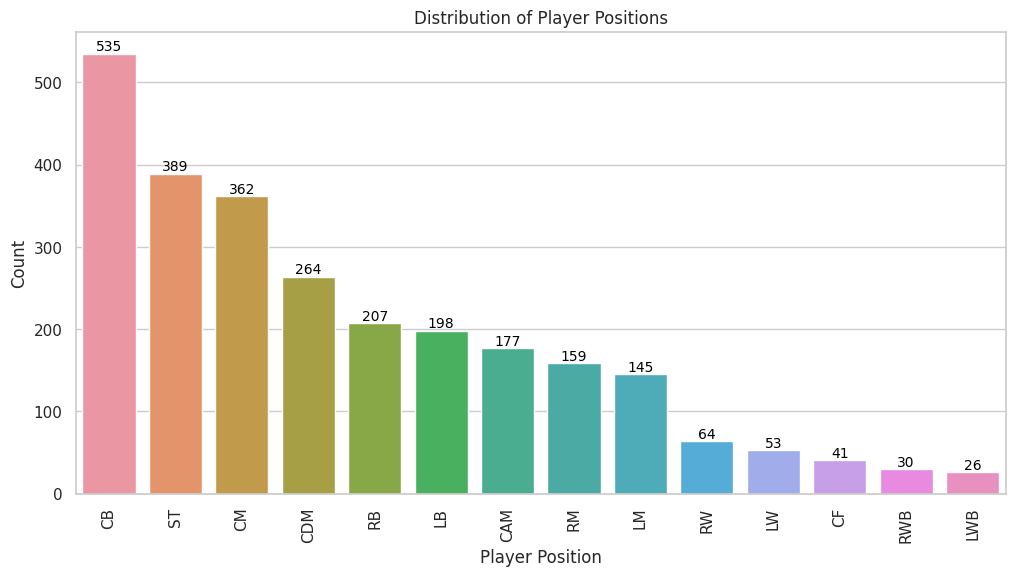

The following Plot is: 



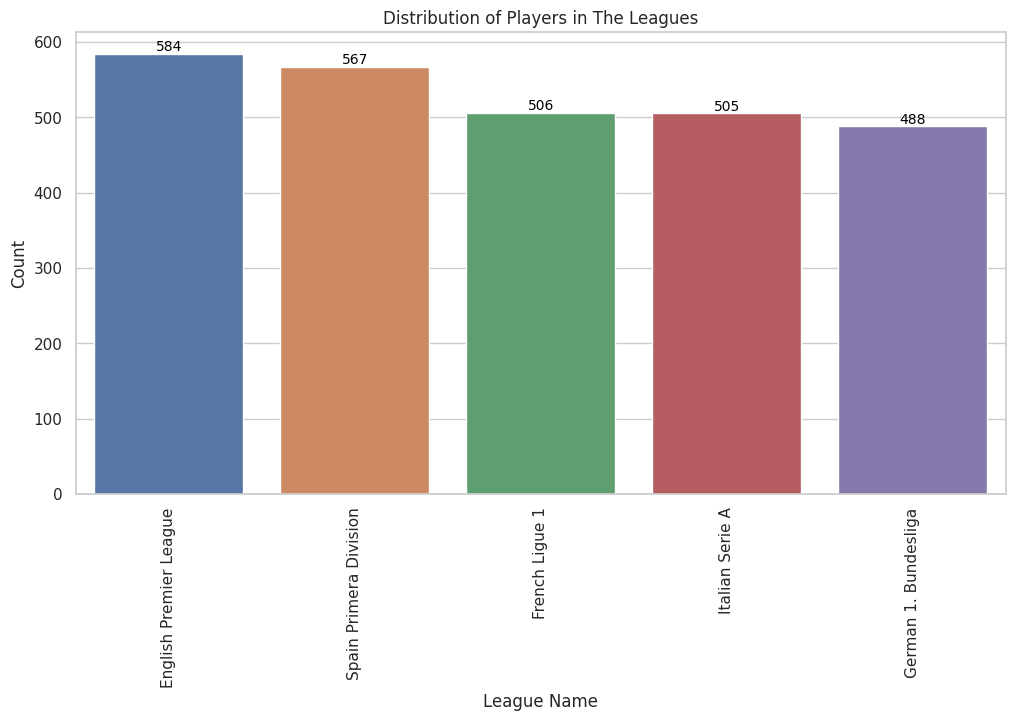

The following Plot is: 



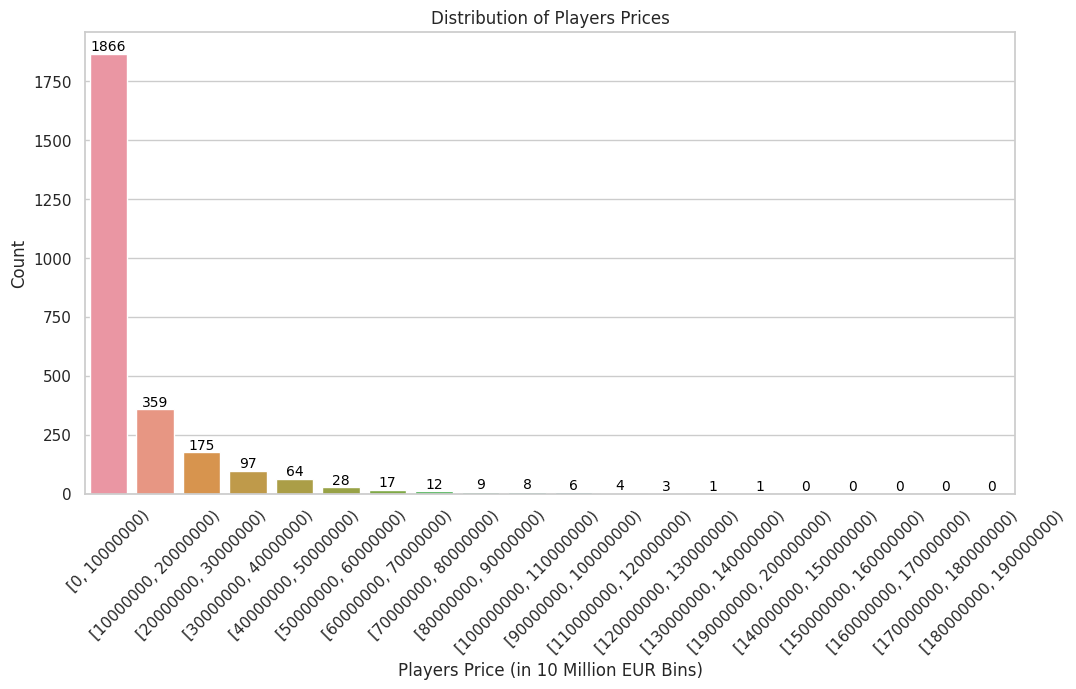

The following Plot is: 



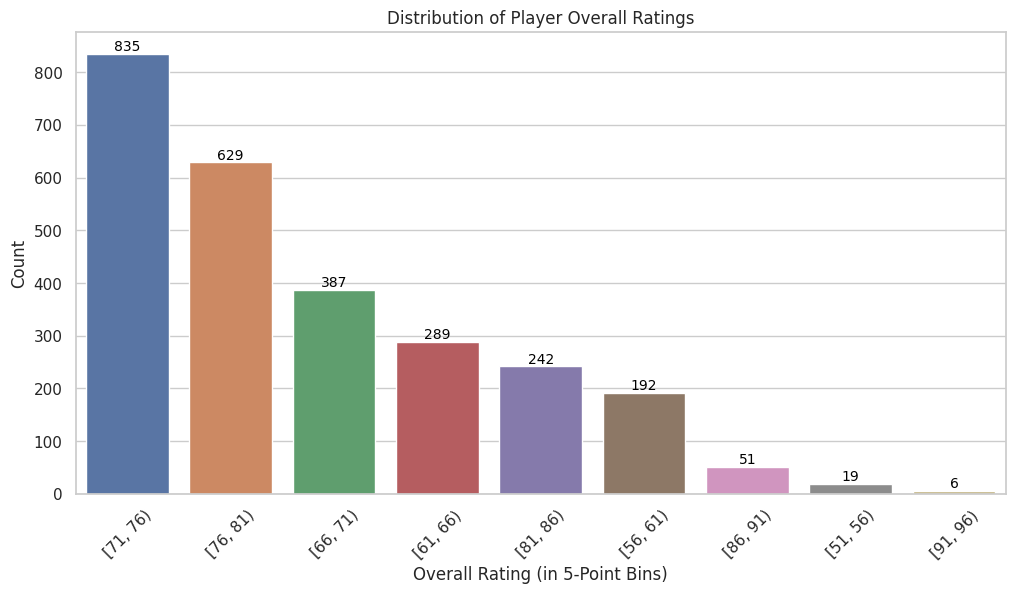

The following Plot is: 



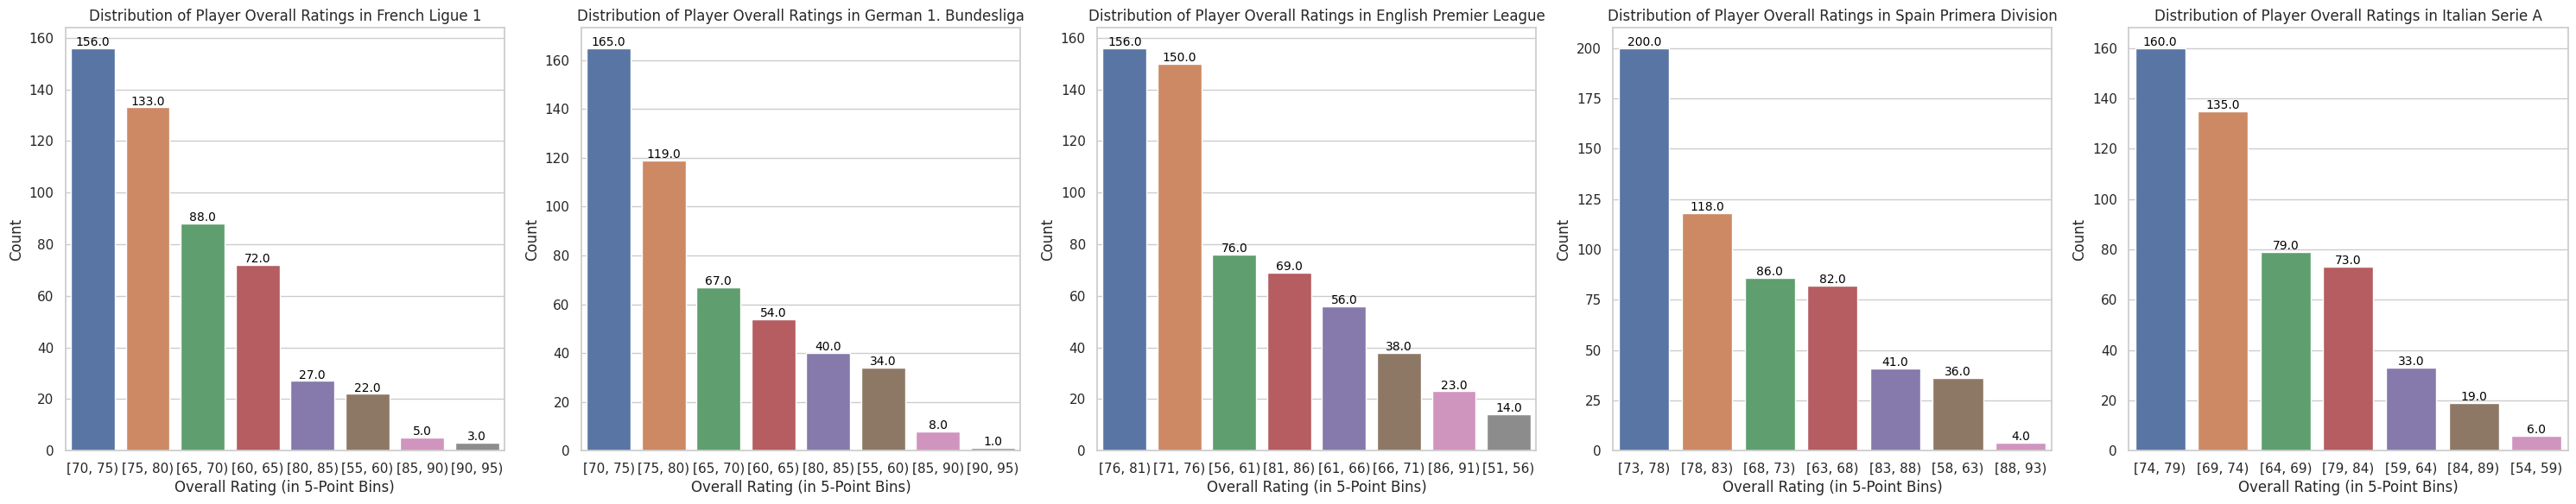

In [9]:
def plot_player_position_distribution(dataframe):
    print("The following Plot is: \n")
    sns.set(style="whitegrid")

    plt.figure(figsize=(12, 6))
    sns.countplot(data=dataframe, x='Player_Position', order=dataframe['Player_Position'].value_counts().index)
    plt.xticks(rotation=90)
    plt.title('Distribution of Player Positions')
    plt.xlabel('Player Position')
    plt.ylabel('Count')

    for bar in plt.gca().patches:
        text_x = bar.get_x() + bar.get_width() / 2.
        text_y = bar.get_height()
        plt.text(text_x, text_y, int(text_y), ha='center', va='bottom', fontsize=10, color='black')

    plt.show()

def plot_player_league_distribution(dataframe):
    print("The following Plot is: \n")
    sns.set(style="whitegrid")

    plt.figure(figsize=(12, 6)) 
    sns.countplot(data=dataframe, x='League_Name', order=dataframe['League_Name'].value_counts().index)
    plt.xticks(rotation=90) 
    plt.title('Distribution of Players in The Leagues')
    plt.xlabel('League Name')
    plt.ylabel('Count')

    for bar in plt.gca().patches:
        text_x = bar.get_x() + bar.get_width() / 2.
        text_y = bar.get_height()
        plt.text(text_x, text_y, int(text_y), ha='center', va='bottom', fontsize=10, color='black')

    plt.show()

def plot_player_price_distribution(dataframe):
    print("The following Plot is: \n")
    sns.set(style="whitegrid")

    plt.figure(figsize=(12, 6))
    sns.countplot(data=dataframe, x='Value_Eur', order=dataframe['Value_Eur'].value_counts().index)
    plt.xticks(rotation=90)
    plt.title('Distribution of Players Prices')
    plt.xlabel('Players Price')
    plt.ylabel('Count')

    for bar in plt.gca().patches:
        text_x = bar.get_x() + bar.get_width() / 2.
        text_y = bar.get_height()
        plt.text(text_x, text_y, int(text_y), ha='center', va='bottom', fontsize=10, color='black')

    plt.show()

def plot_player_price_distribution(dataframe):
    print("The following Plot is: \n")
    sns.set(style="whitegrid")

    max_value = dataframe['Value_Eur'].max()
    bins = [x * 10000000 for x in range(int(max_value / 10000000) + 2)]

    dataframe['Value_Eur_Bin'] = pd.cut(dataframe['Value_Eur'], bins=bins, right=False)

    plt.figure(figsize=(12, 6))
    sns.countplot(data=dataframe, x='Value_Eur_Bin', order=dataframe['Value_Eur_Bin'].value_counts().index)
    plt.xticks(rotation=45)
    plt.title('Distribution of Players Prices')
    plt.xlabel('Players Price (in 10 Million EUR Bins)')
    plt.ylabel('Count')

    for bar in plt.gca().patches:
        text_x = bar.get_x() + bar.get_width() / 2.
        text_y = bar.get_height()
        plt.text(text_x, text_y, int(text_y), ha='center', va='bottom', fontsize=10, color='black')

    plt.show()

def plot_player_overall_distribution(dataframe):
    print("The following Plot is: \n")
    sns.set(style="whitegrid")

    min_value = dataframe['Overall'].min()
    max_value = dataframe['Overall'].max()
    bins = list(range(min_value, max_value + 5, 5))

    dataframe['Overall_Bin'] = pd.cut(dataframe['Overall'], bins=bins, right=False)

    plt.figure(figsize=(12, 6))
    sns.countplot(data=dataframe, x='Overall_Bin', order=dataframe['Overall_Bin'].value_counts().index)
    plt.xticks(rotation=45)
    plt.title('Distribution of Player Overall Ratings')
    plt.xlabel('Overall Rating (in 5-Point Bins)')
    plt.ylabel('Count')

    for bar in plt.gca().patches:
        text_x = bar.get_x() + bar.get_width() / 2.
        text_y = bar.get_height()
        plt.text(text_x, text_y, int(text_y), ha='center', va='bottom', fontsize=10, color='black')

    plt.show()

def plot_player_overall_distribution_by_league(dataframe):
    print("The following Plot is: \n")
    sns.set(style="whitegrid")

    unique_leagues = dataframe['League_Name'].unique()

    num_subplots = len(unique_leagues)
    fig, axes = plt.subplots(1, num_subplots, figsize=(6 * num_subplots, 6))

    for i, league in enumerate(unique_leagues):
        league_df = dataframe[dataframe['League_Name'] == league].copy()

        min_value = league_df['Overall'].min()
        max_value = league_df['Overall'].max()
        bins = list(range(min_value, max_value + 5, 5))

        league_df['Overall_Bin'] = pd.cut(league_df['Overall'], bins=bins, right=False)
        
        sns.countplot(data=league_df, x='Overall_Bin', order=league_df['Overall_Bin'].value_counts().index, ax=axes[i])
        axes[i].set_title(f'Distribution of Player Overall Ratings in {league}')
        axes[i].set_xlabel('Overall Rating (in 5-Point Bins)')
        axes[i].set_ylabel('Count')

        for p in axes[i].patches:
            axes[i].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

    # Adjust the layout
    plt.tight_layout()

plot_player_position_distribution(player_attributes_df)
plot_player_league_distribution(player_attributes_df)
plot_player_price_distribution(player_attributes_df)
plot_player_overall_distribution(player_attributes_df)
plot_player_overall_distribution_by_league(player_attributes_df)

In [10]:
selected_columns = ['Pace', 'Shooting', 'Passing', 'Dribbling', 'Defending', 'Physic', 'Attacking_Crossing', 'Attacking_Finishing',
                    'Attacking_Heading_Accuracy', 'Attacking_Short_Passing', 'Attacking_Volleys', 'Skill_Dribbling', 'Skill_Curve',
                    'Skill_Fk_Accuracy', 'Skill_Long_Passing', 'Skill_Ball_Control', 'Movement_Acceleration', 'Movement_Sprint_Speed',
                    'Movement_Agility', 'Movement_Reactions', 'Movement_Balance', 'Power_Shot_Power', 'Power_Jumping', 'Power_Stamina',
                    'Power_Strength', 'Power_Long_Shots', 'Mentality_Aggression', 'Mentality_Interceptions', 'Mentality_Positioning',
                    'Mentality_Vision', 'Mentality_Penalties', 'Mentality_Composure', 'Defending_Marking_Awareness', 'Defending_Standing_Tackle',
                    'Defending_Sliding_Tackle']

filtered_df = player_attributes_df[selected_columns]

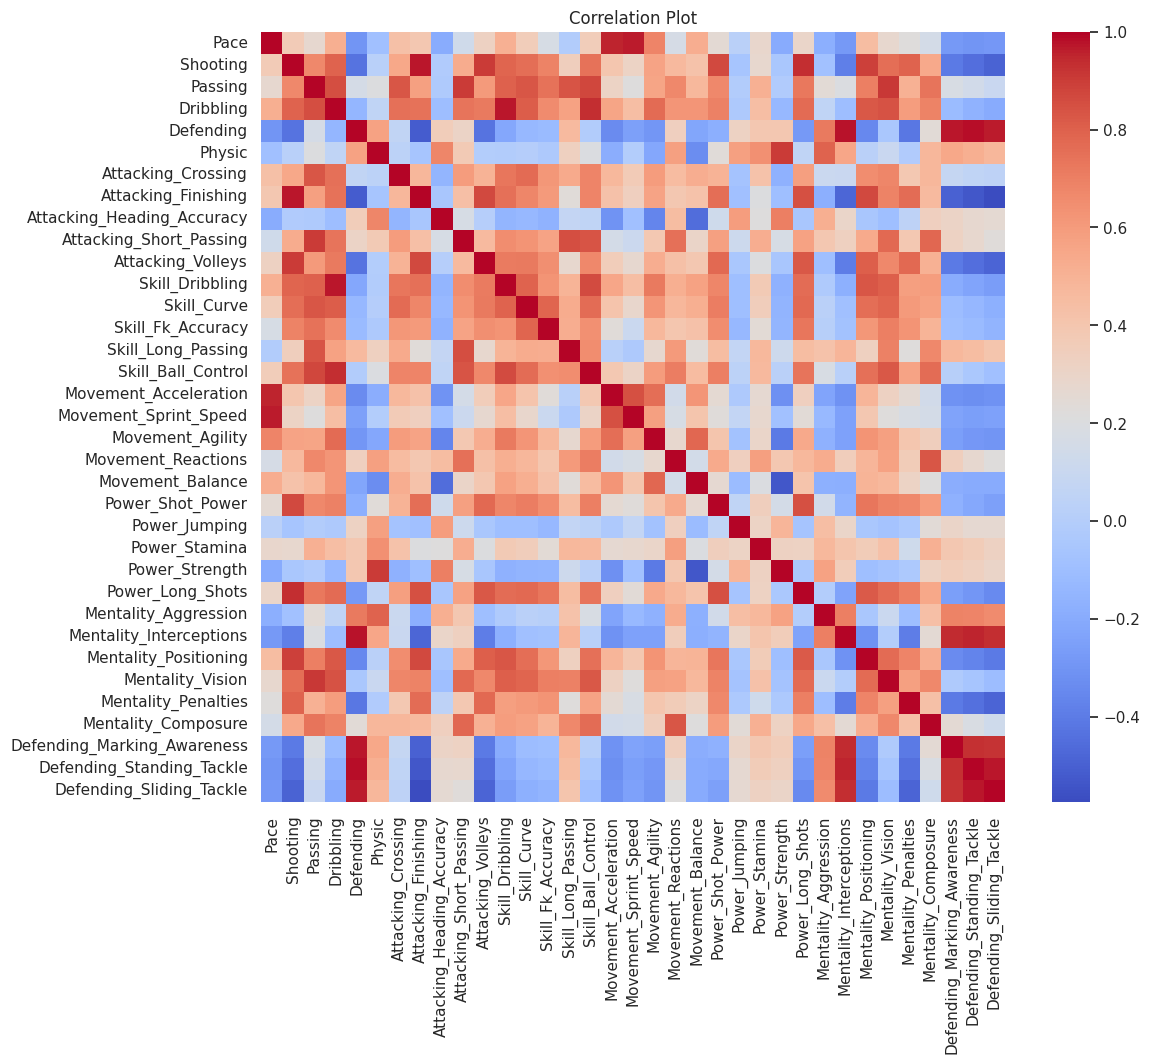

In [11]:
def plot_correlation(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Plot')
    plt.show()

plot_correlation(filtered_df)

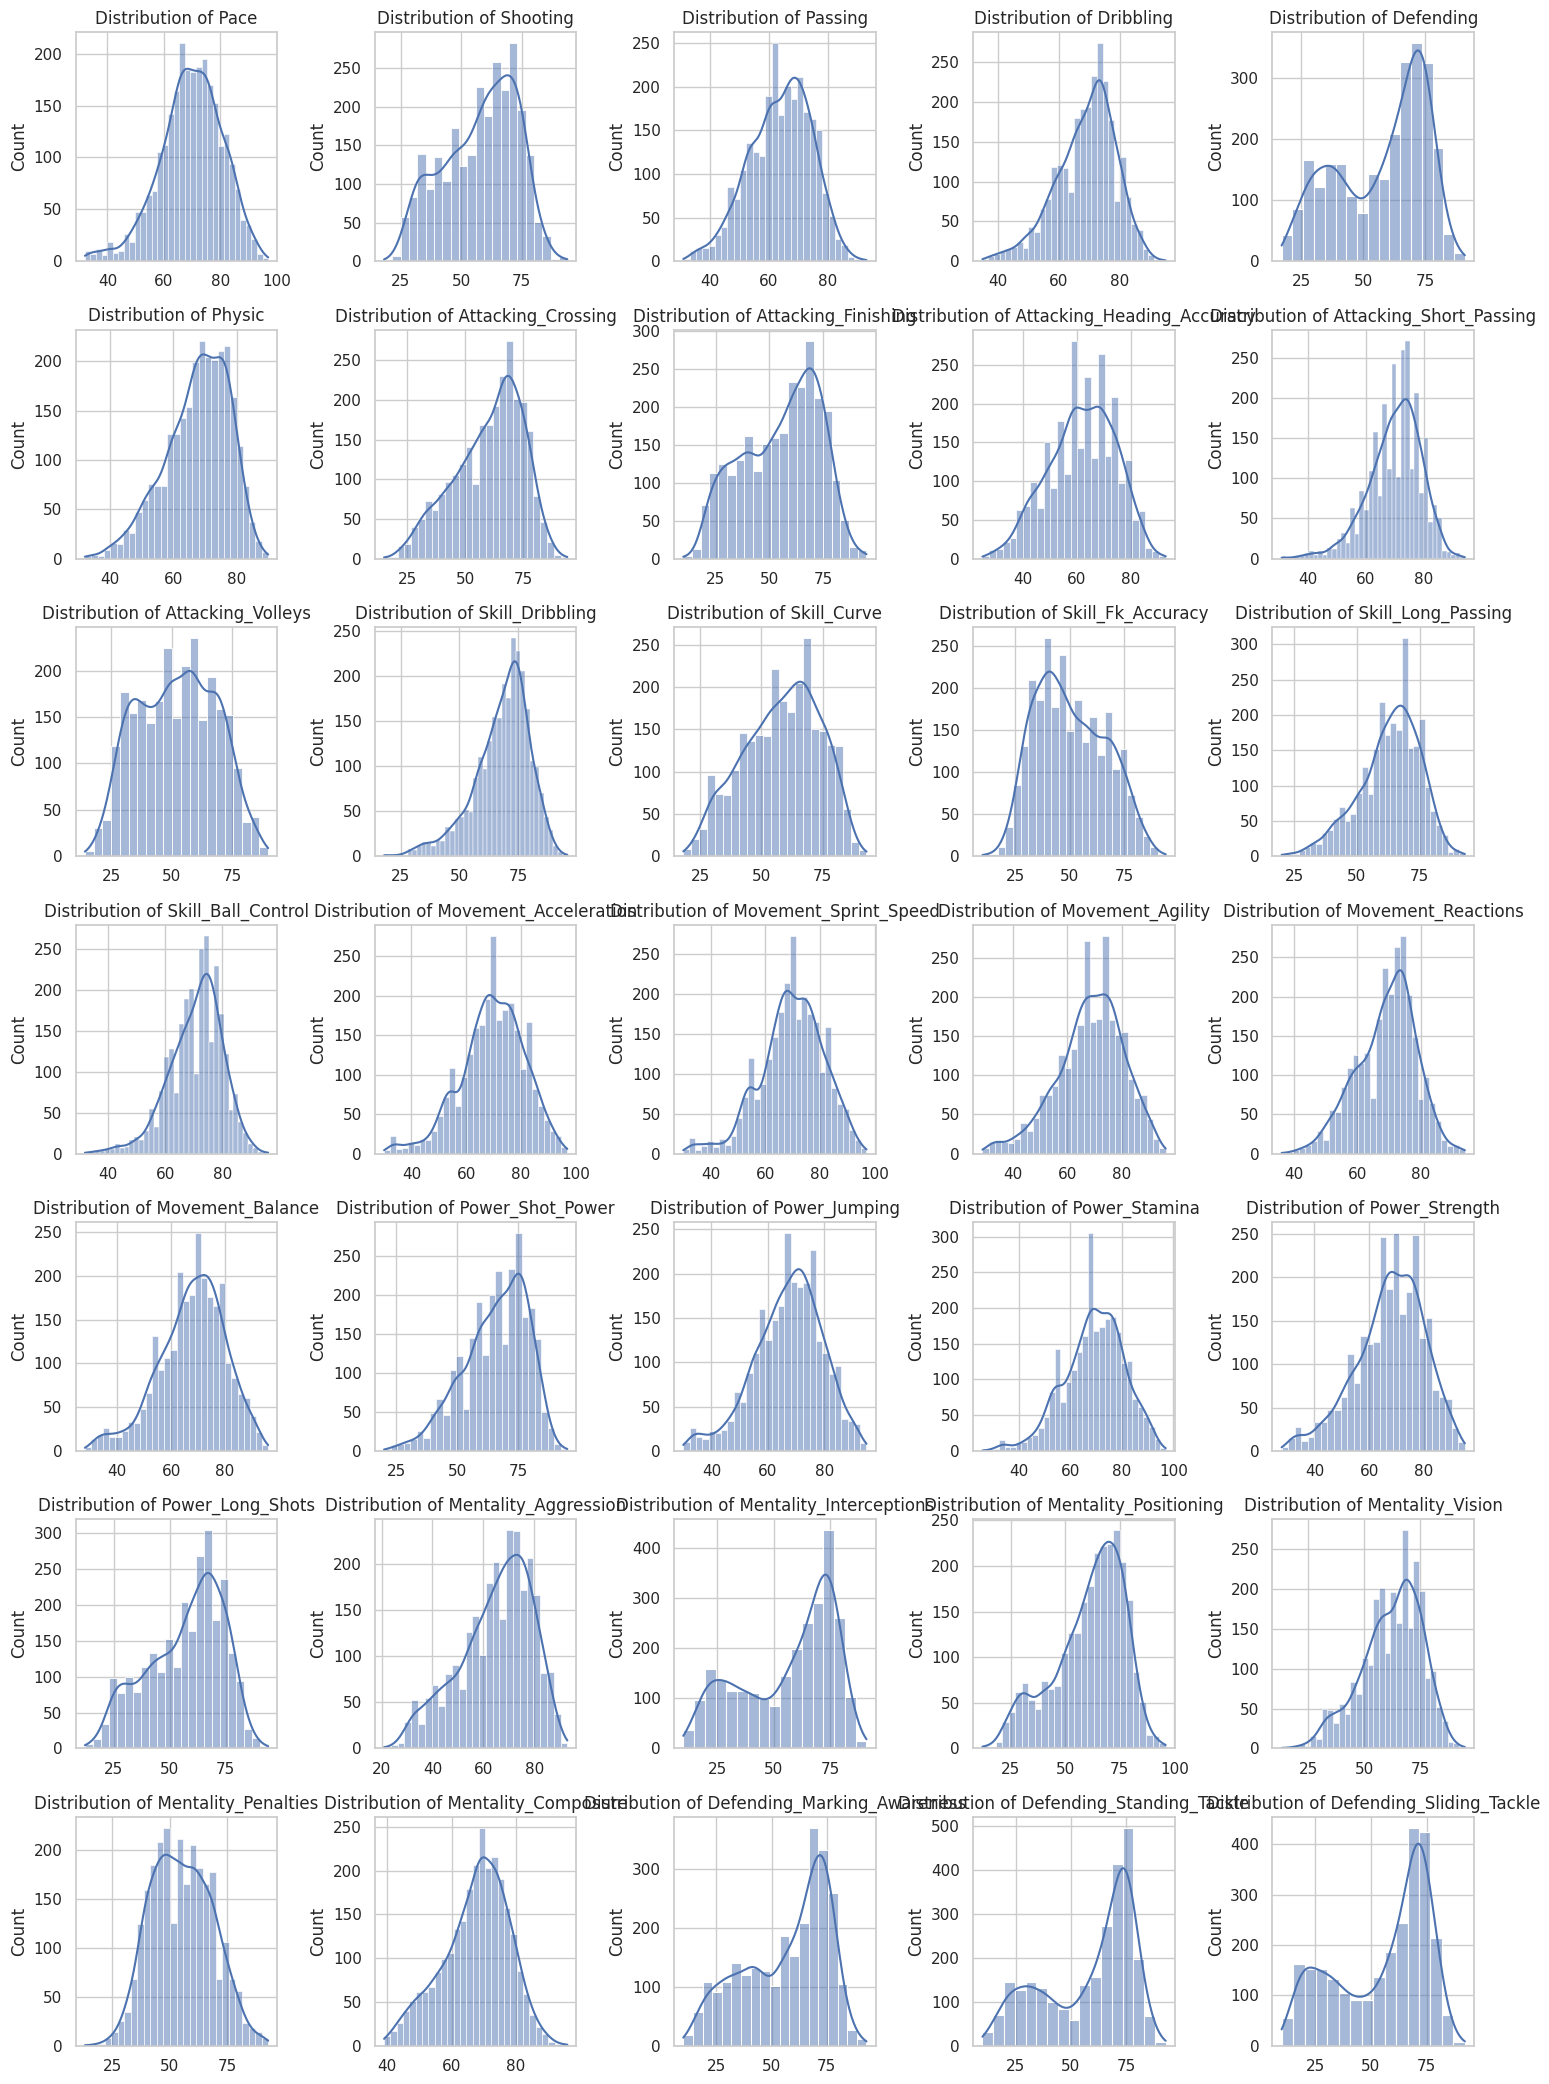

In [12]:
def plot_distribution(dataframe, selected_columns):
    num_cols = min(len(selected_columns), 5)
    num_rows = (len(selected_columns) - 1) // num_cols + 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    axes = axes.flatten()

    for i, col in enumerate(selected_columns):
        sns.histplot(data=dataframe, x=col, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Count')

    for i in range(len(selected_columns), num_rows * num_cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

plot_distribution(filtered_df[selected_columns], selected_columns)


# PCA

In [14]:
selected_columns = ['Player_Position', 'Pace', 'Shooting', 'Passing', 'Dribbling', 'Defending', 'Physic', 'Attacking_Crossing', 'Attacking_Finishing',
                    'Attacking_Heading_Accuracy', 'Attacking_Short_Passing', 'Attacking_Volleys', 'Skill_Dribbling', 'Skill_Curve',
                    'Skill_Fk_Accuracy', 'Skill_Long_Passing', 'Skill_Ball_Control', 'Movement_Acceleration', 'Movement_Sprint_Speed',
                    'Movement_Agility', 'Movement_Reactions', 'Movement_Balance', 'Power_Shot_Power', 'Power_Jumping', 'Power_Stamina',
                    'Power_Strength', 'Power_Long_Shots', 'Mentality_Aggression', 'Mentality_Interceptions', 'Mentality_Positioning',
                    'Mentality_Vision', 'Mentality_Penalties', 'Mentality_Composure', 'Defending_Marking_Awareness', 'Defending_Standing_Tackle',
                    'Defending_Sliding_Tackle']

player_df = player_attributes_df[selected_columns]
player_df.head()

,Player_Position,Pace,Shooting,Passing,Dribbling,Defending,Physic,Attacking_Crossing,Attacking_Finishing,Attacking_Heading_Accuracy,...,Power_Long_Shots,Mentality_Aggression,Mentality_Interceptions,Mentality_Positioning,Mentality_Vision,Mentality_Penalties,Mentality_Composure,Defending_Marking_Awareness,Defending_Standing_Tackle,Defending_Sliding_Tackle
0,RW,85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,...,94,44,40,93,95,75,96,20,35,24
1,ST,78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,...,87,81,49,95,81,90,88,35,42,19
2,ST,87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,...,93,63,29,95,76,88,95,24,32,24
3,LW,91.0,83.0,86.0,94.0,37.0,63.0,85,83,63,...,81,63,37,86,90,93,93,35,32,29
4,CM,76.0,86.0,93.0,88.0,64.0,78.0,94,82,55,...,91,76,66,88,94,83,89,68,65,53


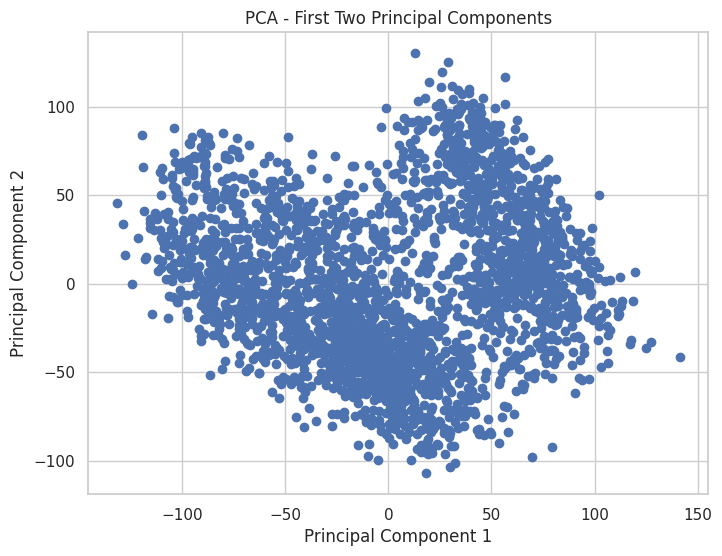

In [15]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(filtered_df)

principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 6))
plt.scatter(principalDf['PC1'], principalDf['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First Two Principal Components')
plt.show()

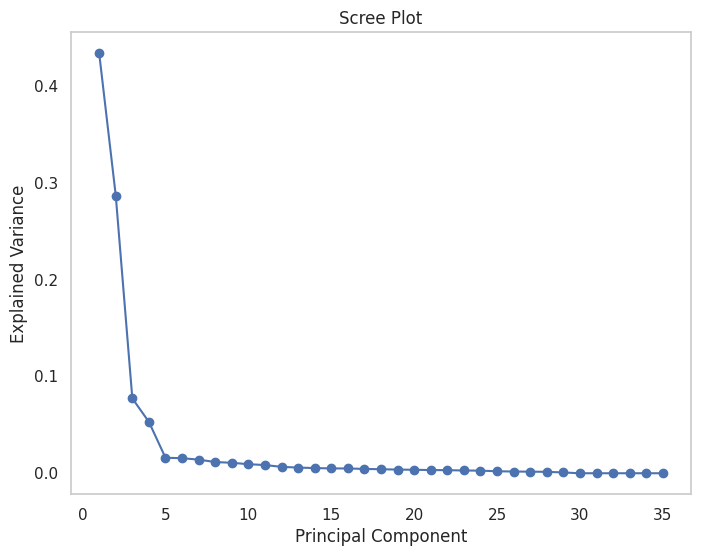

Principal Component 1 explains 43.35% of the variance.
Principal Component 2 explains 28.67% of the variance.
Principal Component 3 explains 7.72% of the variance.
Principal Component 4 explains 5.30% of the variance.
Principal Component 5 explains 1.60% of the variance.
Principal Component 6 explains 1.56% of the variance.
Principal Component 7 explains 1.41% of the variance.
Principal Component 8 explains 1.16% of the variance.
Principal Component 9 explains 1.08% of the variance.
Principal Component 10 explains 0.94% of the variance.
Principal Component 11 explains 0.85% of the variance.
Principal Component 12 explains 0.66% of the variance.
Principal Component 13 explains 0.59% of the variance.
Principal Component 14 explains 0.54% of the variance.
Principal Component 15 explains 0.50% of the variance.
Principal Component 16 explains 0.49% of the variance.
Principal Component 17 explains 0.45% of the variance.
Principal Component 18 explains 0.41% of the variance.
Principal Compone

In [16]:
def plot_pca_scree(pca_model, data):
    pca_model.fit(data)
    explained_variance = pca_model.explained_variance_ratio_

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance')
    plt.grid()
    plt.show()

    components = pca.components_
    for i in range(len(components)):
        print(f"Principal Component {i + 1} explains {explained_variance[i] * 100:.2f}% of the variance.")

    return explained_variance

pca = PCA()
explained_variance = plot_pca_scree(pca, filtered_df)
# PC1 and PC2 explain 72.02 of the variance

In [18]:
def print_top_loading_scores(pca_model, data, component_index, top_n=10):
    pca_model.fit(data)
    loading_scores = pca_model.components_[component_index]

    attribute_scores = np.abs(loading_scores)

    attribute_scores_df = pd.DataFrame({'Attribute': data.columns, 'Score': attribute_scores})

    attribute_scores_df = attribute_scores_df.sort_values(by='Score', ascending=False)

    top_attributes = attribute_scores_df['Attribute'].head(top_n)

    for i, attribute in enumerate(top_attributes):
        loading_score = loading_scores[i]
        print(f'Attribute {i + 1}: Loading Score {loading_score:.4f} - {attribute}')


X = pca.transform(filtered_df)[:, 0]  
Y = pca.transform(filtered_df)[:, 1] 

pca_data = pd.DataFrame({'X': X, 'Y': Y})

pca_data.index = filtered_df.index

print("DataFrame with the X and Y coordinates: \n")
print(pca_data.head())
correlation_coefficient = np.corrcoef(X, Y)[0, 1]
print(f'\nCorrelation Coefficient: {correlation_coefficient}')
print("\nFirst Component: \n")
print_top_loading_scores(pca, filtered_df, component_index=0, top_n=10)
print("\nSecond Component: \n")
print_top_loading_scores(pca, filtered_df, component_index=1, top_n=10)

DataFrame with the X and Y coordinates: 

            X          Y
0  141.558524 -41.621812
1  106.530757 -44.931528
2  127.396346 -32.984515
3  124.825584 -36.186879
4   79.351439 -92.259110

Correlation Coefficient: 1.4741584203520414e-16

First Component: 

Attribute 1: Loading Score 0.1036 - Attacking_Finishing
Attribute 2: Loading Score 0.2494 - Defending_Sliding_Tackle
Attribute 3: Loading Score 0.1026 - Defending_Standing_Tackle
Attribute 4: Loading Score 0.1332 - Attacking_Volleys
Attribute 5: Loading Score -0.2318 - Shooting
Attribute 6: Loading Score -0.0516 - Mentality_Interceptions
Attribute 7: Loading Score 0.1364 - Power_Long_Shots
Attribute 8: Loading Score 0.2943 - Mentality_Positioning
Attribute 9: Loading Score -0.0564 - Defending_Marking_Awareness
Attribute 10: Loading Score 0.0554 - Defending

Second Component: 

Attribute 1: Loading Score -0.0128 - Mentality_Interceptions
Attribute 2: Loading Score -0.1029 - Defending_Standing_Tackle
Attribute 3: Loading Score -0.1

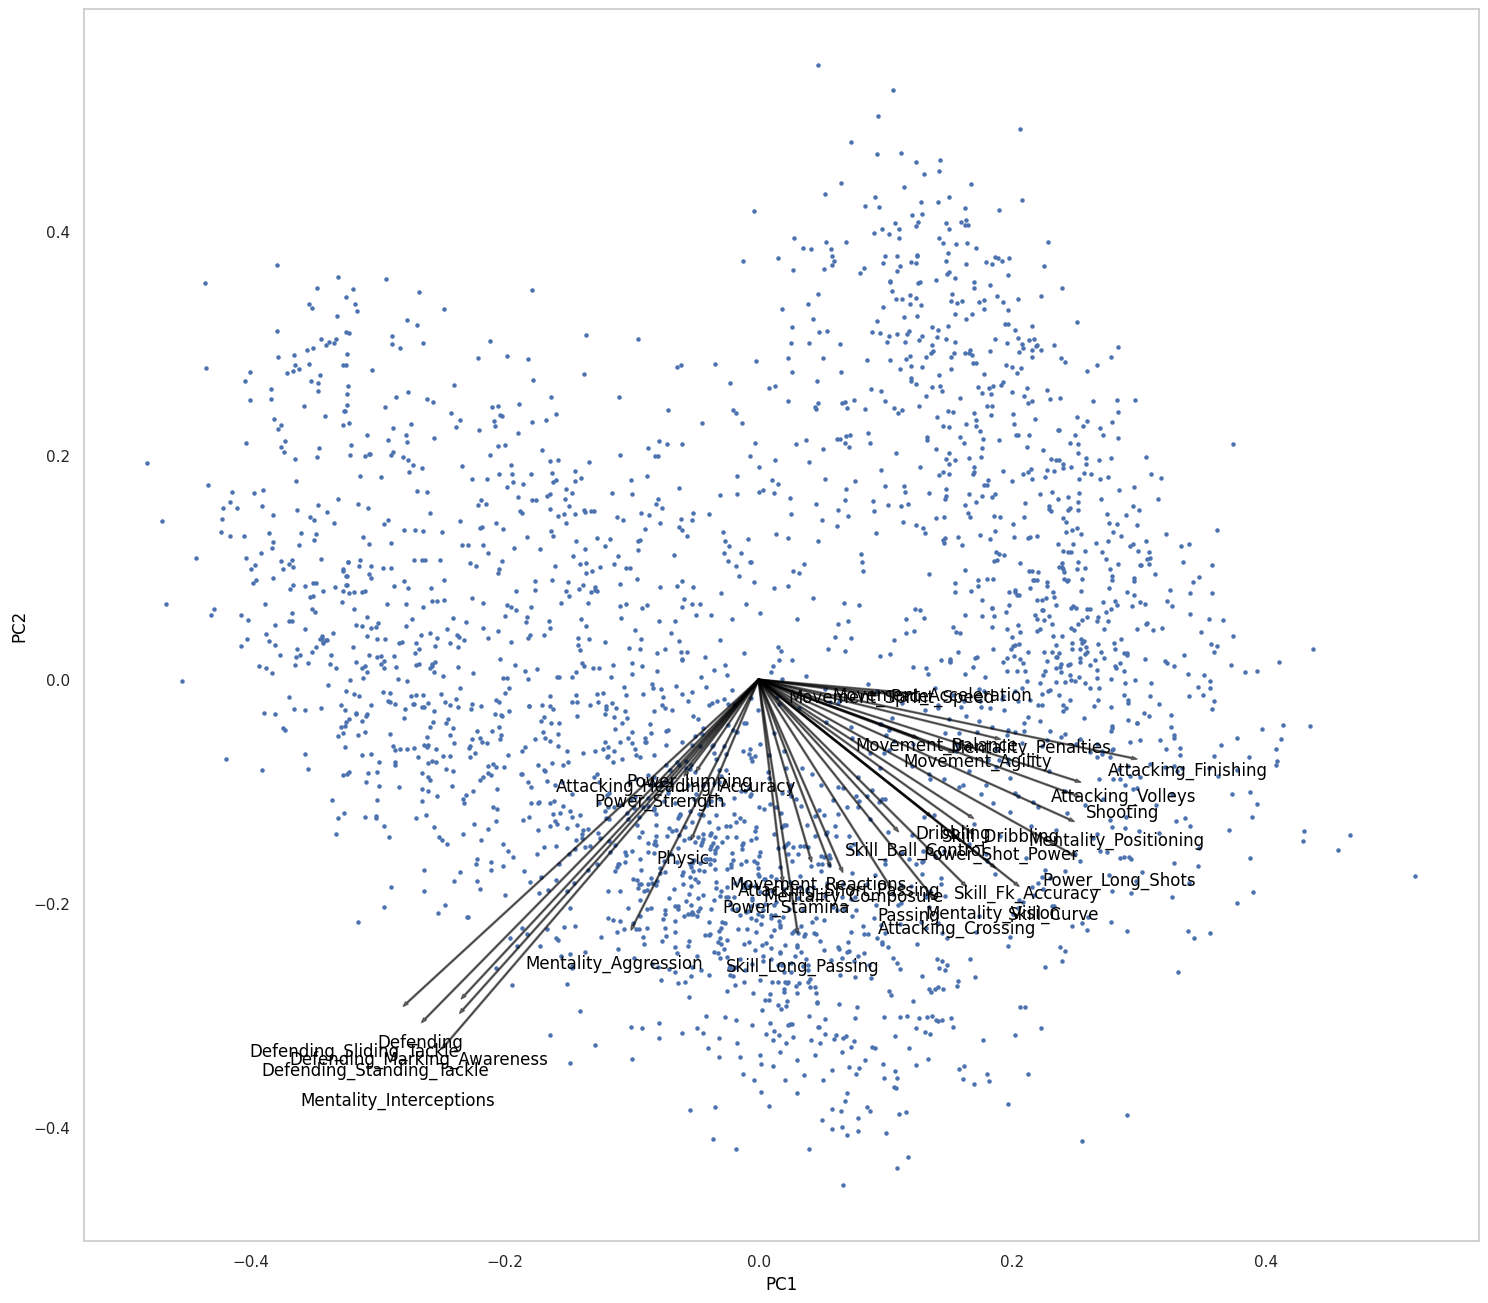

In [19]:
def biplot(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]

    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())

    plt.figure(figsize=(18, 16))
    plt.scatter(xs * scalex, ys * scaley, s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='black', alpha=0.5)  
        if labels is None:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, "Var" + str(i + 1), color='black', ha='center', va='center')  
        else:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='black', ha='center', va='center')  

    plt.xlabel("PC1", color='black')
    plt.ylabel("PC2", color='black')
    plt.grid()

biplot(principalComponents, np.transpose(pca.components_), labels=filtered_df.columns)
plt.show()


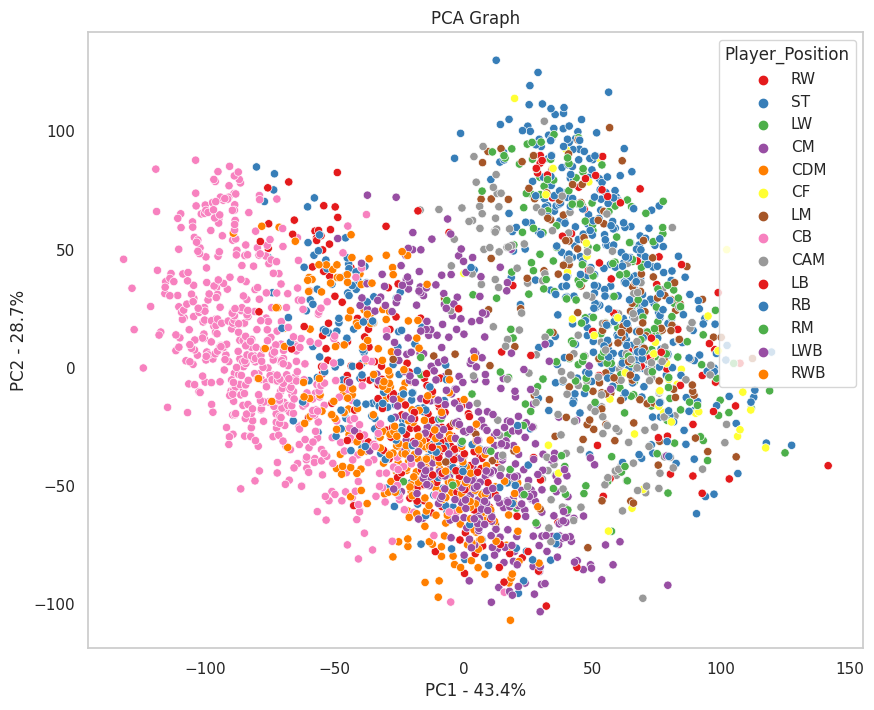

In [20]:
def plot_pca_scatter(df, principal_components, explained_variance, x_label='PC1', y_label='PC2'):
    explained_variance_percentages = explained_variance * 100

    df_copy = df.copy()

    df_copy['PC1'] = principal_components[:, 0]
    df_copy['PC2'] = principal_components[:, 1]

    plt.figure(figsize=(10, 8))

    sns.scatterplot(data=df_copy, x='PC1', y='PC2', hue='Player_Position', palette='Set1')

    plt.xlabel(f'{x_label} - {explained_variance_percentages[0]:.1f}%')
    plt.ylabel(f'{y_label} - {explained_variance_percentages[1]:.1f}%')
    plt.title('PCA Graph')

    plt.grid()
    plt.show()

plot_pca_scatter(player_df, principalComponents, explained_variance)

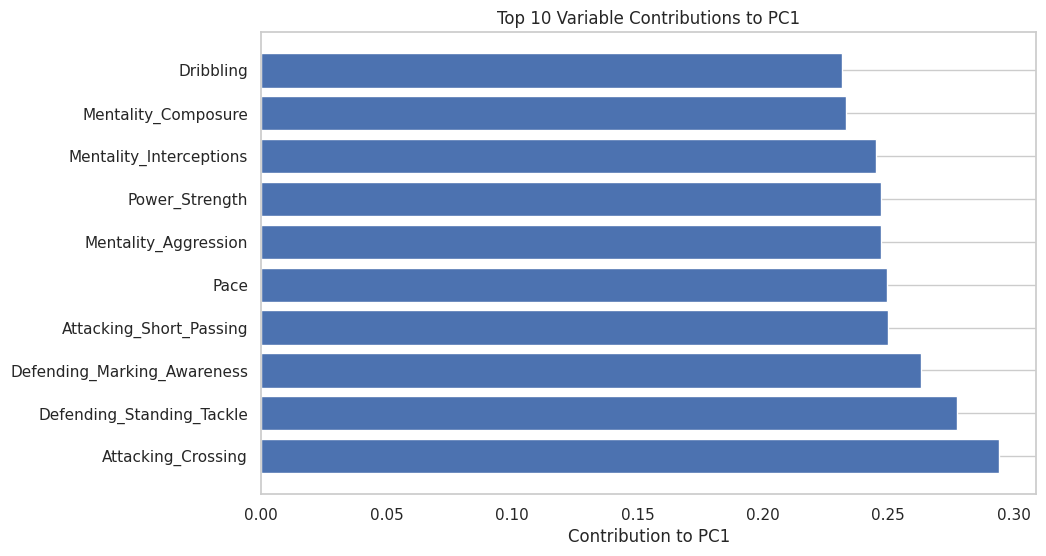

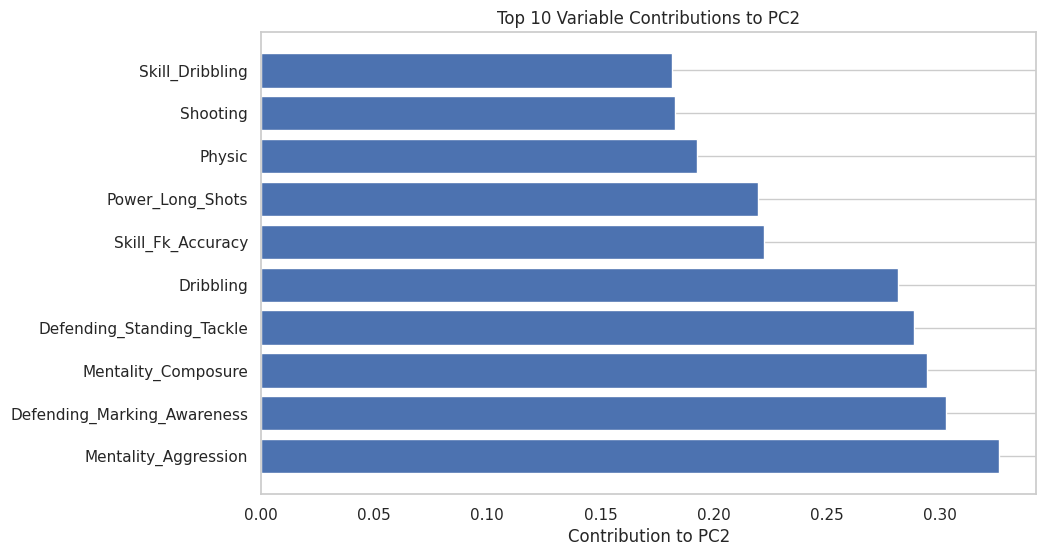

In [21]:
def plot_top_variable_contributions(pca, component_index, top_n=10):
    contributions = pca.components_[component_index]
    abs_contributions = np.abs(contributions)
    top_contributions = np.argsort(abs_contributions)[::-1][:top_n]
    variable_names = player_df.columns[top_contributions]

    plt.figure(figsize=(10, 6))
    plt.barh(variable_names, abs_contributions[top_contributions])
    plt.xlabel(f'Contribution to PC{component_index + 1}')
    plt.title(f'Top {top_n} Variable Contributions to PC{component_index + 1}')
    plt.grid(axis='x')
    plt.show()

plot_top_variable_contributions(pca, component_index=0)
plot_top_variable_contributions(pca, component_index=1)

In [22]:
def pca_and_linear_regression(df, dependent_variable, num_components=2):
    explained_variance = pca.explained_variance_ratio_
    explained_variance_percentages = explained_variance * 100
    player_df = df.copy()
    player_df['PC1'] = principalComponents[:, 0]
    player_df['PC2'] = principalComponents[:, 1]

    pca_regression_df = player_df[['Overall', 'PC1', 'PC2']]

    X = pca_regression_df[['PC1', 'PC2']]
    X = sm.add_constant(X)  # Adding a constant (intercept) to the model
    y = pca_regression_df['Overall']

    model = sm.OLS(y, X).fit()

    return model

selected_columns = ['Overall', 'Player_Position', 'Pace', 'Shooting', 'Passing', 'Dribbling', 'Defending', 'Physic', 'Attacking_Crossing', 'Attacking_Finishing',
                    'Attacking_Heading_Accuracy', 'Attacking_Short_Passing', 'Attacking_Volleys', 'Skill_Dribbling', 'Skill_Curve',
                    'Skill_Fk_Accuracy', 'Skill_Long_Passing', 'Skill_Ball_Control', 'Movement_Acceleration', 'Movement_Sprint_Speed',
                    'Movement_Agility', 'Movement_Reactions', 'Movement_Balance', 'Power_Shot_Power', 'Power_Jumping', 'Power_Stamina',
                    'Power_Strength', 'Power_Long_Shots', 'Mentality_Aggression', 'Mentality_Interceptions', 'Mentality_Positioning',
                    'Mentality_Vision', 'Mentality_Penalties', 'Mentality_Composure', 'Defending_Marking_Awareness', 'Defending_Standing_Tackle',
                    'Defending_Sliding_Tackle']

player_df = player_attributes_df[selected_columns]
model = pca_and_linear_regression(player_df, dependent_variable='Overall')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Overall   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     2789.
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        01:03:55   Log-Likelihood:                -7475.2
No. Observations:                2650   AIC:                         1.496e+04
Df Residuals:                    2647   BIC:                         1.497e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.3958      0.079    916.771      0.0

# MANOVA

In [23]:
def assign_general_position(player_df):
    df = player_df.copy()
    conditions = [
        (df['Player_Position'].isin(['RW', 'LW', 'ST', 'CF'])),
        (df['Player_Position'].isin(['LM', 'RM', 'CAM', 'CM', 'CDM']))
    ]

    values = ['Attacker', 'Midfielder']

    df.loc[:, 'General_Position'] = np.select(conditions, values, default='Defender')

    first_quartile = df['Overall'].quantile(0.25)
    third_quartile = df['Overall'].quantile(0.75)

    conditions = [
        (df['Overall'] < first_quartile),
        (df['Overall'] > third_quartile)
    ]

    values = ['Low', 'High']

    df.loc[:, 'Player_Overall_Level'] = np.select(conditions, values, default='Average')
    df = df.drop(columns=['Overall', 'Player_Position'])
    return df

# Example usage:
player_df = assign_general_position(player_df)
player_df.head()

,Pace,Shooting,Passing,Dribbling,Defending,Physic,Attacking_Crossing,Attacking_Finishing,Attacking_Heading_Accuracy,Attacking_Short_Passing,...,Mentality_Interceptions,Mentality_Positioning,Mentality_Vision,Mentality_Penalties,Mentality_Composure,Defending_Marking_Awareness,Defending_Standing_Tackle,Defending_Sliding_Tackle,General_Position,Player_Overall_Level
0,85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,...,40,93,95,75,96,20,35,24,Attacker,High
1,78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,...,49,95,81,90,88,35,42,19,Attacker,High
2,87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,...,29,95,76,88,95,24,32,24,Attacker,High
3,91.0,83.0,86.0,94.0,37.0,63.0,85,83,63,86,...,37,86,90,93,93,35,32,29,Attacker,High
4,76.0,86.0,93.0,88.0,64.0,78.0,94,82,55,94,...,66,88,94,83,89,68,65,53,Midfielder,High


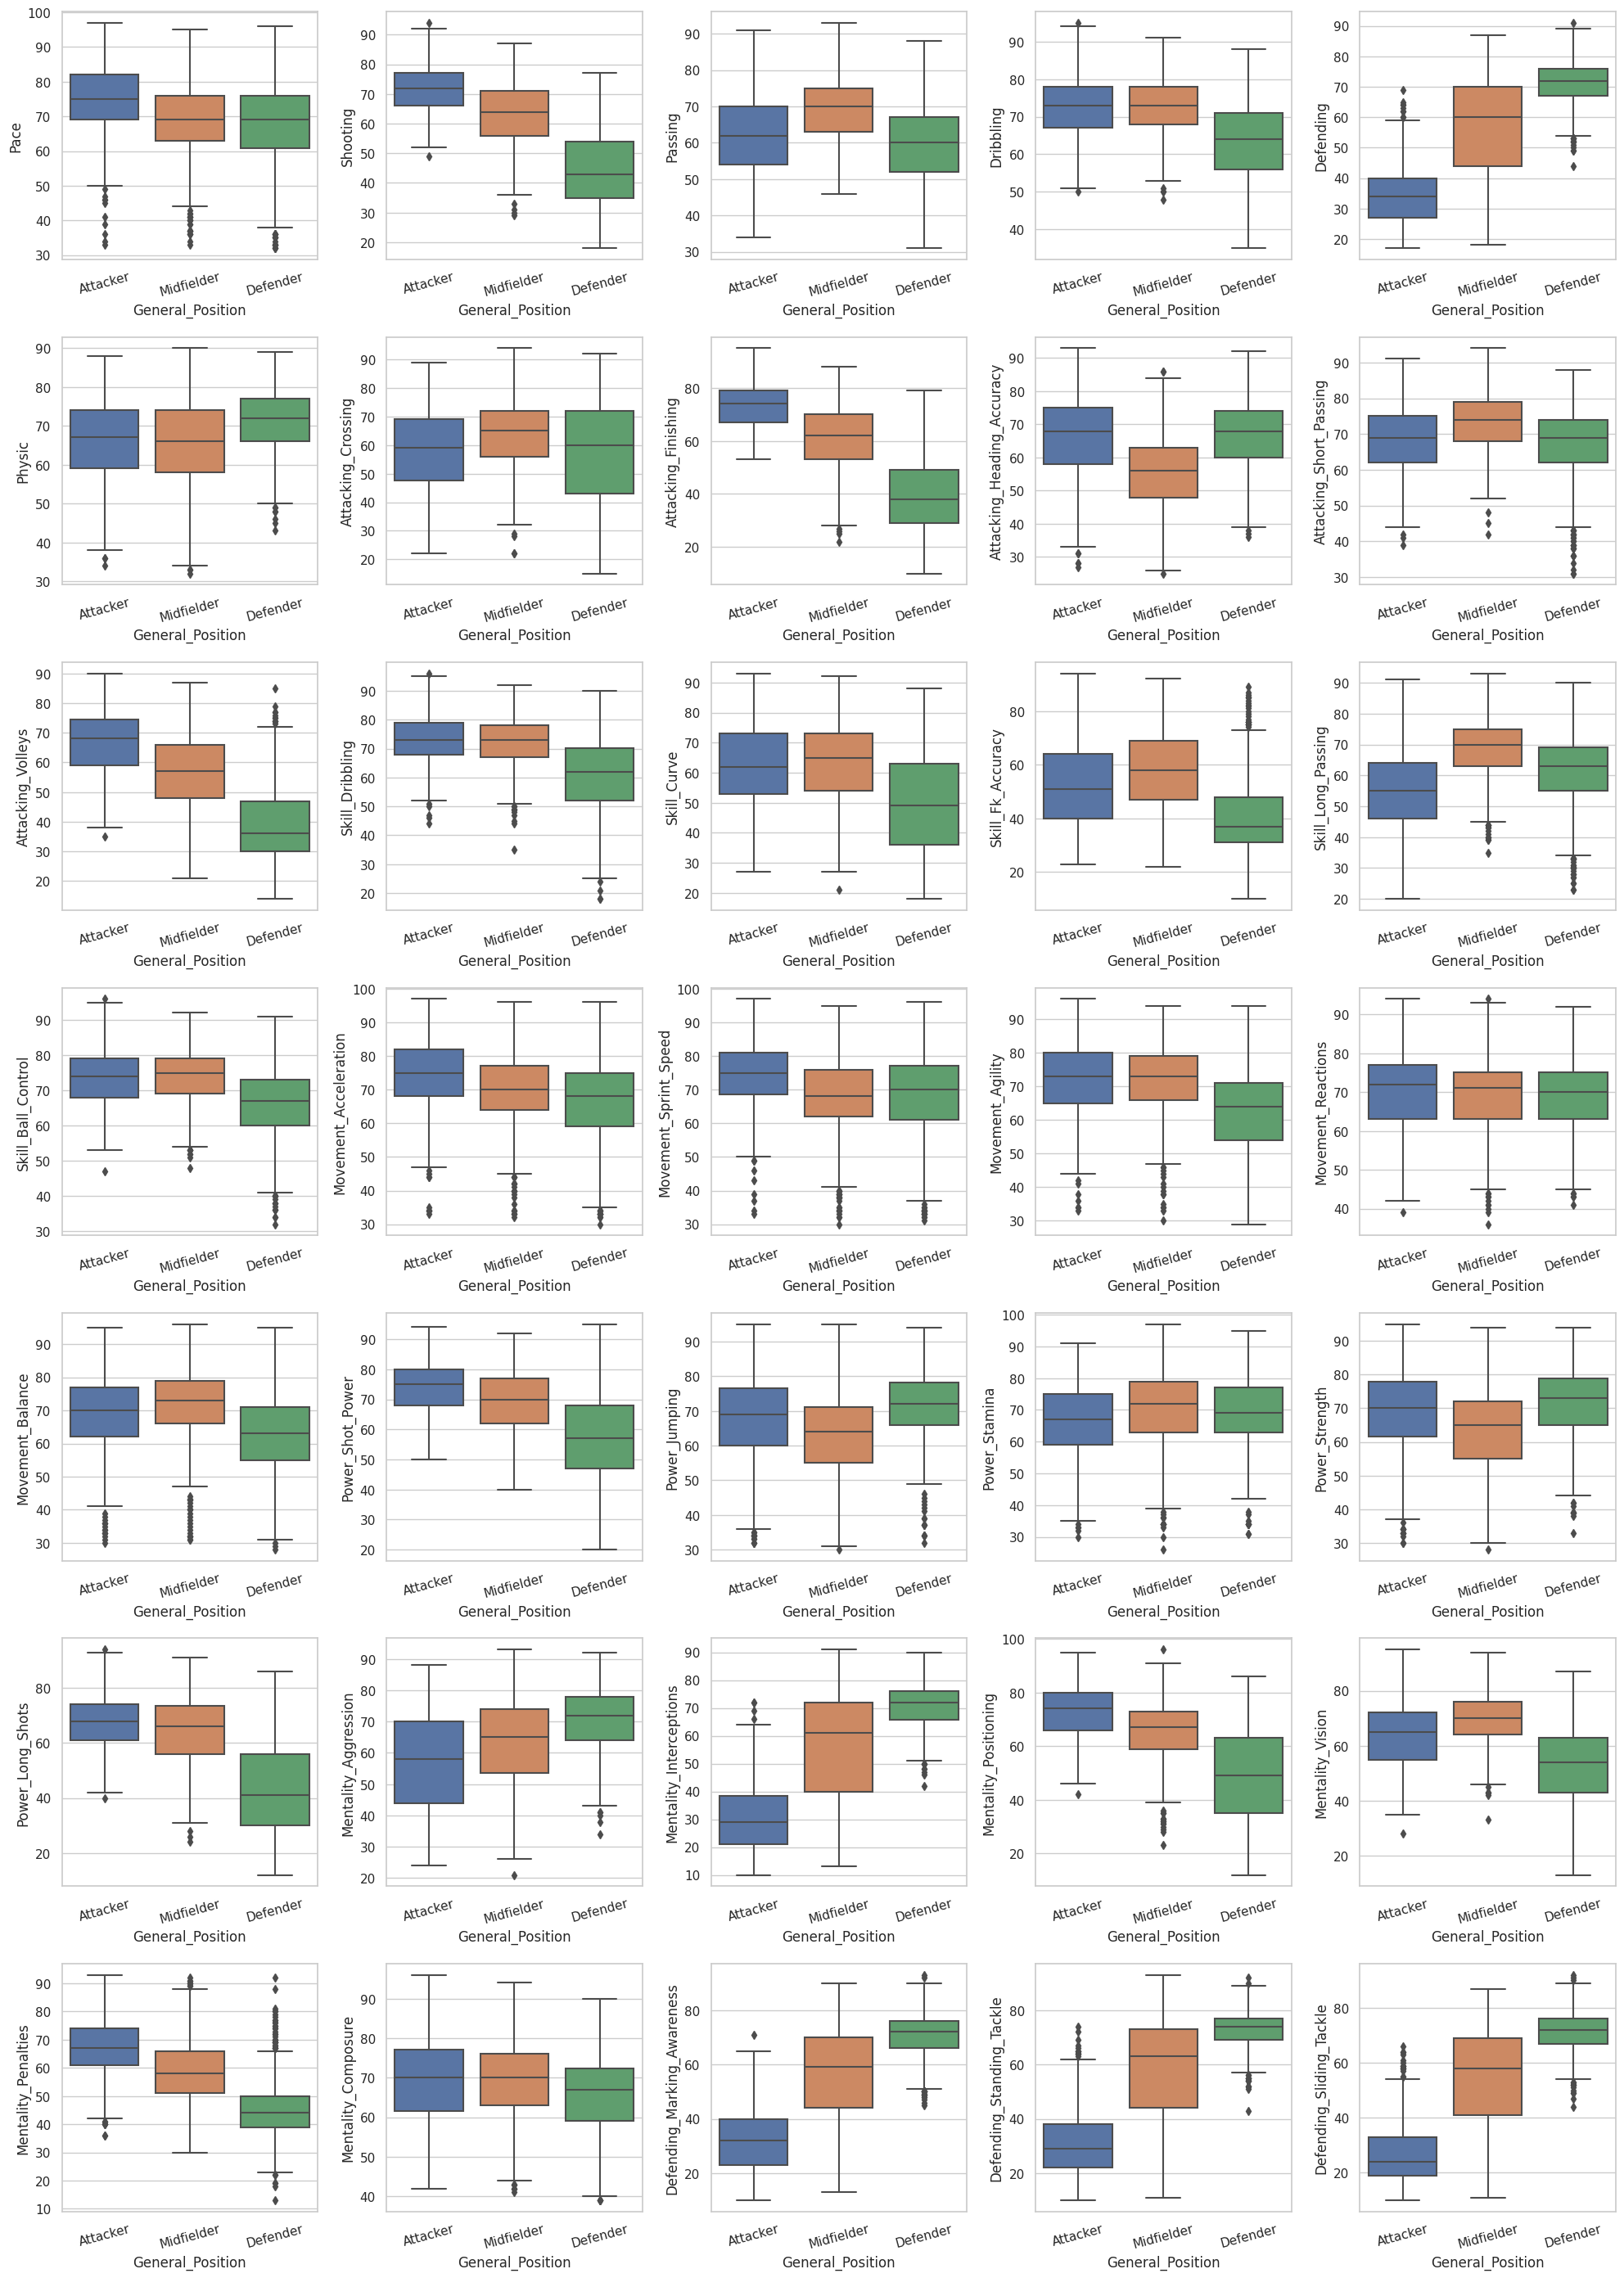

In [24]:
def create_boxplots_for_numerical_attributes(df, numerical_columns, category_column, ncols=5):
    n = len(numerical_columns)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, 4 * nrows))

    for i, attribute in enumerate(numerical_columns):
        row, col = divmod(i, ncols)
        ax = axs[row, col]

        sns.boxplot(data=df, x=category_column, y=attribute, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=15)

    for i in range(n, nrows * ncols):
        row, col = divmod(i, ncols)
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

numerical_columns = ['Pace', 'Shooting', 'Passing', 'Dribbling', 'Defending', 'Physic', 'Attacking_Crossing', 'Attacking_Finishing',
                    'Attacking_Heading_Accuracy', 'Attacking_Short_Passing', 'Attacking_Volleys', 'Skill_Dribbling', 'Skill_Curve',
                    'Skill_Fk_Accuracy', 'Skill_Long_Passing', 'Skill_Ball_Control', 'Movement_Acceleration', 'Movement_Sprint_Speed',
                    'Movement_Agility', 'Movement_Reactions', 'Movement_Balance', 'Power_Shot_Power', 'Power_Jumping', 'Power_Stamina',
                    'Power_Strength', 'Power_Long_Shots', 'Mentality_Aggression', 'Mentality_Interceptions', 'Mentality_Positioning',
                    'Mentality_Vision', 'Mentality_Penalties', 'Mentality_Composure', 'Defending_Marking_Awareness', 'Defending_Standing_Tackle',
                    'Defending_Sliding_Tackle']

player_df[numerical_columns] = player_df[numerical_columns].astype('int64')
create_boxplots_for_numerical_attributes(player_df, numerical_columns=numerical_columns, category_column='General_Position')

In [25]:
def perform_shapiro_wilk_test(df, numerical_columns):
    shapiro_results = {}
    for column in numerical_columns:
        stat, p = shapiro(df[column])
        shapiro_results[column] = (stat, p)

    for column, (stat, p) in shapiro_results.items():
        print(f'Shapiro-Wilk Test for "{column}": Statistic={stat}, p-value={p:.5f}')

perform_shapiro_wilk_test(player_df, numerical_columns=numerical_columns)

Shapiro-Wilk Test for "Pace": Statistic=0.9853806495666504, p-value=0.00000
Shapiro-Wilk Test for "Shooting": Statistic=0.9670935273170471, p-value=0.00000
Shapiro-Wilk Test for "Passing": Statistic=0.9895201325416565, p-value=0.00000
Shapiro-Wilk Test for "Dribbling": Statistic=0.9781668782234192, p-value=0.00000
Shapiro-Wilk Test for "Defending": Statistic=0.9231054782867432, p-value=0.00000
Shapiro-Wilk Test for "Physic": Statistic=0.9718323945999146, p-value=0.00000
Shapiro-Wilk Test for "Attacking_Crossing": Statistic=0.9686995148658752, p-value=0.00000
Shapiro-Wilk Test for "Attacking_Finishing": Statistic=0.9643842577934265, p-value=0.00000
Shapiro-Wilk Test for "Attacking_Heading_Accuracy": Statistic=0.9895935654640198, p-value=0.00000
Shapiro-Wilk Test for "Attacking_Short_Passing": Statistic=0.9734395742416382, p-value=0.00000
Shapiro-Wilk Test for "Attacking_Volleys": Statistic=0.9802194833755493, p-value=0.00000
Shapiro-Wilk Test for "Skill_Dribbling": Statistic=0.955052256

In [26]:
def bootstrap_shapiro_wilk_test(df, numerical_columns, num_bootstraps=1000, alpha=0.05):
    bootstrapped_shapiro_results = {column: {'statistics': [], 'p-values': []} for column in numerical_columns}

    for column in numerical_columns:
        original_data = df[column]
        n = len(original_data)

        for _ in range(num_bootstraps):
            bootstrap_sample = np.random.choice(original_data, size=n, replace=True)
            stat, p = shapiro(bootstrap_sample)
            bootstrapped_shapiro_results[column]['statistics'].append(stat)
            bootstrapped_shapiro_results[column]['p-values'].append(p)

    confidence_intervals = {}
    for column, results in bootstrapped_shapiro_results.items():
        statistics = results['statistics']
        p_values = results['p-values']
        stat_ci = np.percentile(statistics, [100 * alpha / 2, 100 * (1 - alpha / 2)])
        p_value_ci = np.percentile(p_values, [100 * alpha / 2, 100 * (1 - alpha / 2)])
        confidence_intervals[column] = {'statistic': stat_ci, 'p-value': p_value_ci}

    for column, intervals in confidence_intervals.items():
        print(f'Confidence Intervals for "{column}":')
        print(f'Shapiro-Wilk Statistic: {intervals["statistic"]}')
        print(f'Shapiro-Wilk p-value: {intervals["p-value"]}\n')

bootstrap_shapiro_wilk_test(player_df, numerical_columns=numerical_columns, num_bootstraps=1000, alpha=0.05)

Confidence Intervals for "Pace":
Shapiro-Wilk Statistic: [0.97971317 0.98932077]
Shapiro-Wilk p-value: [5.28905282e-19 3.48900927e-13]

Confidence Intervals for "Shooting":
Shapiro-Wilk Statistic: [0.96139502 0.97173776]
Shapiro-Wilk p-value: [5.22199928e-26 1.82032386e-22]

Confidence Intervals for "Passing":
Shapiro-Wilk Statistic: [0.98528506 0.99195256]
Shapiro-Wilk p-value: [6.03505996e-16 5.48208506e-11]

Confidence Intervals for "Dribbling":
Shapiro-Wilk Statistic: [0.97162651 0.98312218]
Shapiro-Wilk p-value: [1.64893405e-22 3.24103929e-17]

Confidence Intervals for "Defending":
Shapiro-Wilk Statistic: [0.91569591 0.92942498]
Shapiro-Wilk p-value: [4.28807066e-36 1.20290131e-33]

Confidence Intervals for "Physic":
Shapiro-Wilk Statistic: [0.9658395  0.97671144]
Shapiro-Wilk p-value: [1.38056382e-24 2.08865097e-20]

Confidence Intervals for "Attacking_Crossing":
Shapiro-Wilk Statistic: [0.96254361 0.97359253]
Shapiro-Wilk p-value: [1.18335952e-25 9.87483553e-22]

Confidence Inte

In [27]:
manova_model = MANOVA.from_formula('Pace + Shooting + Passing + Dribbling + Defending + Physic + \
                                    Attacking_Crossing + Attacking_Finishing + Attacking_Heading_Accuracy + \
                                    Attacking_Short_Passing + Attacking_Volleys + Skill_Dribbling + Skill_Curve + \
                                    Skill_Fk_Accuracy + Skill_Long_Passing + Skill_Ball_Control + Movement_Acceleration + \
                                    Movement_Sprint_Speed + Movement_Agility + Movement_Reactions + Movement_Balance + \
                                    Power_Shot_Power + Power_Jumping + Power_Stamina + Power_Strength + Power_Long_Shots + \
                                    Mentality_Aggression + Mentality_Interceptions + Mentality_Positioning + Mentality_Vision + Mentality_Penalties + \
                                    Mentality_Composure + Defending_Marking_Awareness + Defending_Standing_Tackle + Defending_Sliding_Tackle ~ General_Position', data=player_df)

manova_result = manova_model.mv_test()
print(manova_result)

                    Multivariate linear model
                                                                  
------------------------------------------------------------------
       Intercept         Value   Num DF   Den DF   F Value  Pr > F
------------------------------------------------------------------
          Wilks' lambda  0.0218 35.0000 2613.0000 3343.7755 0.0000
         Pillai's trace  0.9782 35.0000 2613.0000 3343.7755 0.0000
 Hotelling-Lawley trace 44.7884 35.0000 2613.0000 3343.7755 0.0000
    Roy's greatest root 44.7884 35.0000 2613.0000 3343.7755 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
      General_Position    Value   Num DF   Den DF  F Value  Pr > F
------------------------------------------------------------------
            Wilks' lambda 0.1008 70.0000 5226.0000 160.5418 0.0000
           Pilla

# CANONICAL CORRELATION ANALYSIS

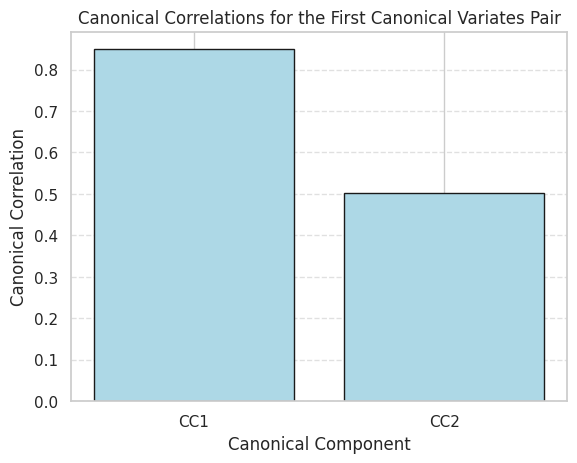

Canonical Correlation (CC1): 0.8490119398205261
Canonical Correlation (CC2): 0.5034510371815626


In [34]:
def perform_cca(player_attributes_df, player_df, player_main_characteristics, football_attributes, n_components=2):
    characteristics_data = player_attributes_df[player_main_characteristics].values
    football_data = player_df[football_attributes].values
    categories = player_df['Player_Overall_Level'].values

    cca = CCA(n_components=n_components)
    cca.fit(characteristics_data, football_data)

    characteristics_c, football_c = cca.transform(characteristics_data, football_data)

    comp_corr = [np.corrcoef(characteristics_c[:, i], football_c[:, i])[1][0] for i in range(n_components)]

    plt.bar(['CC1', 'CC2'], comp_corr, color='lightblue', width=0.8, edgecolor='k')
    plt.xlabel('Canonical Component')
    plt.ylabel('Canonical Correlation')
    plt.title('Canonical Correlations for the First Canonical Variates Pair')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

    first_canonical_corr = comp_corr[0]
    print(f"Canonical Correlation (CC1): {first_canonical_corr}")

    second_canonical_corr = comp_corr[1]
    print(f"Canonical Correlation (CC2): {second_canonical_corr}")

    return cca, comp_corr, characteristics_c, football_c


player_main_characteristics = ['Value_Eur', 'Wage_Eur','International_Reputation', 'Age']
football_attributes = ['Pace', 'Shooting', 'Passing', 'Dribbling', 'Attacking_Crossing',
                      'Attacking_Finishing', 'Attacking_Heading_Accuracy', 'Attacking_Short_Passing',
                      'Attacking_Volleys', 'Skill_Dribbling', 'Skill_Curve', 'Skill_Fk_Accuracy',
                      'Skill_Long_Passing', 'Skill_Ball_Control', 'Movement_Acceleration',
                      'Movement_Sprint_Speed', 'Movement_Agility', 'Movement_Reactions', 'Movement_Balance',
                      'Power_Shot_Power', 'Power_Long_Shots', 'Mentality_Vision', 'Mentality_Penalties',
                      'Defending', 'Physic','Power_Jumping', 'Power_Stamina', 'Power_Strength', 'Mentality_Aggression',
                      'Mentality_Interceptions', 'Mentality_Positioning', 'Mentality_Composure',
                      'Defending_Marking_Awareness', 'Defending_Standing_Tackle', 'Defending_Sliding_Tackle']

cca, comp_corr, characteristics_c, football_c = perform_cca(player_attributes_df, player_df, player_main_characteristics, football_attributes, n_components=2)

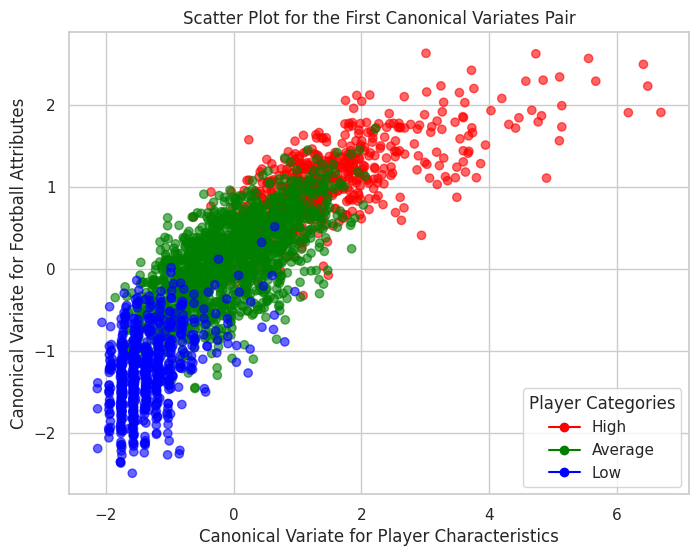

In [46]:
def plot_cca_scatter(characteristics_c, football_c, categories):
    colormap = {
        'High': 'red',
        'Average': 'green',
        'Low': 'blue',
    }

    colors = [colormap[category] for category in categories]

    canonical_variates_1 = characteristics_c[:, 0]
    canonical_variates_2 = football_c[:, 0]

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(canonical_variates_1, canonical_variates_2, c=colors, alpha=0.6)

    plt.xlabel('Canonical Variate for Player Characteristics')
    plt.ylabel('Canonical Variate for Football Attributes')
    plt.title('Scatter Plot for the First Canonical Variates Pair')

    legend_handles = [Line2D([0], [0], marker='o', color=color, markerfacecolor=color, label=category)
                      for category, color in colormap.items()]

    plt.legend(handles=legend_handles, title='Player Categories', loc='lower right')
    plt.show()

plot_cca_scatter(characteristics_c, football_c, player_df['Player_Overall_Level'].values)

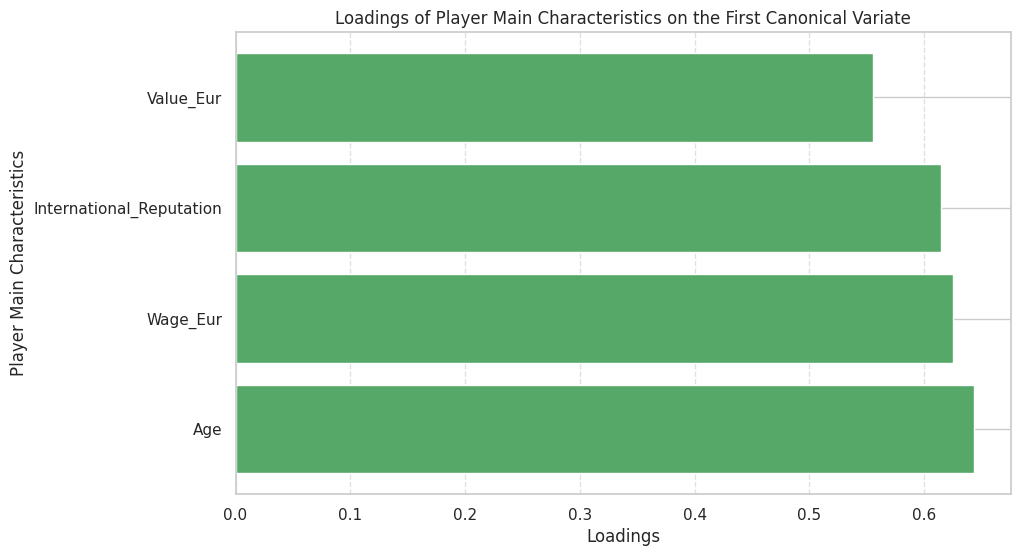

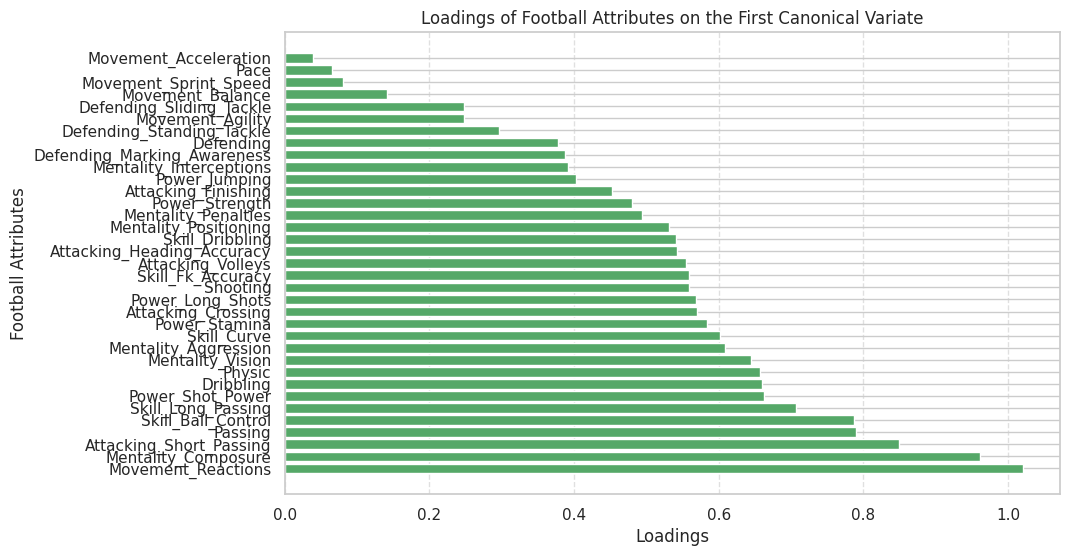

In [30]:
def plot_loadings(variables, loadings, title, ylabel, color='auto'):
    plt.figure(figsize=(10, 6))
    if color == 'auto':
        color = ['g' if load > 0 else 'r' for load in loadings]
    plt.barh(variables, loadings, color=color)
    plt.xlabel('Loadings')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

def plot_player_characteristics_loadings(player_main_characteristics, player_characteristics_loadings):
    loadings = player_characteristics_loadings[:, 0]

    positive_loadings = [(variable, loading) for variable, loading in zip(player_main_characteristics, loadings) if loading > 0]

    negative_loadings = [(variable, loading) for variable, loading in zip(player_main_characteristics, loadings) if loading < 0]

    positive_loadings.sort(key=lambda x: abs(x[1]), reverse=True)
    negative_loadings.sort(key=lambda x: abs(x[1]), reverse=True)

    variables = [item[0] for item in positive_loadings + negative_loadings]
    loadings = [item[1] for item in positive_loadings + negative_loadings]

    plot_loadings(variables, loadings, 'Loadings of Player Main Characteristics on the First Canonical Variate',
                  'Player Main Characteristics')

def plot_football_attributes_loadings(football_attributes, football_attributes_loadings):
    loadings = football_attributes_loadings[:, 0]

    positive_loadings = [(variable, loading) for variable, loading in zip(football_attributes, loadings) if loading > 0]

    negative_loadings = [(variable, loading) for variable, loading in zip(football_attributes, loadings) if loading < 0]

    positive_loadings.sort(key=lambda x: abs(x[1]), reverse=True)
    negative_loadings.sort(key=lambda x: abs(x[1]), reverse=True)

    variables = [item[0] for item in positive_loadings + negative_loadings]
    loadings = [item[1] for item in positive_loadings + negative_loadings]

    plot_loadings(variables, loadings, 'Loadings of Football Attributes on the First Canonical Variate',
                  'Football Attributes')


player_characteristics_loadings = cca.x_loadings_
football_attributes_loadings = cca.y_loadings_
plot_player_characteristics_loadings(player_main_characteristics, player_characteristics_loadings)
plot_football_attributes_loadings(football_attributes, football_attributes_loadings)